### Модель для расчета распределения ошибок олигосинтеза с учетом образования укороченных и удлиненных цепей олигонуклеотидов###

Ошибка может произойти на стадии снятия DMT защиты, на стадии конденсации c вероятностью R, на стадии кэпированя с вероятностью E, а также, что в каждом цикле после удачного протекания конденсации с вероятностью L может произойти еще одна дополнительная конденсация.
Для расчета вероятнстей (долей) получения всех возможных продуктов олигосинтеза с заданными вероятнстями ошибок будем использовать следующий подход: 

На первом цикле рассчитываем вероятность (в нашем случае, это то же самое что и доля либо количество) получения всех возможных продуктов – защищенного DMT группой димера, тримера, мономера, ацетилированного мономера и мономера со свободной 5’ гидроксильной группой. Далее, во втором цикле берем по отдельности каждый из этих продуктов и для него считаем количество всех возможных продуктов после окончания второго цикла. И так далее. В конце, после последнего цикла на выходе из программы мы получаем вероятности (доли) всех возможных продуктов синтеза. 

Для хранения информации о количестве получаемых продуктов заведем три списка: permanent_list - в него последовательно на каждом цикле будет добавляться ацетилированный (trancated) продукт, который на последующих циклах в реакцию вступать больше не может; temp_list_2 - список, в который на каждом цикле будет считаться количество всех возможных образовавшихся продуктов из продуктов (всех, кроме ацетилированных) предыдущего цикла, которые хранятся в temp_list_1. В конце каждого цикла temp_list_1 обновляется, а temp_list_2 обнуляется. И тот и другой список представляют собой двойной массив. Первый столбец ([i][0]) соответствует 5’ DMT-защищенным олиго, второй столбец ([i][1]) - олиго с 5' свободной гидроксигруппой.


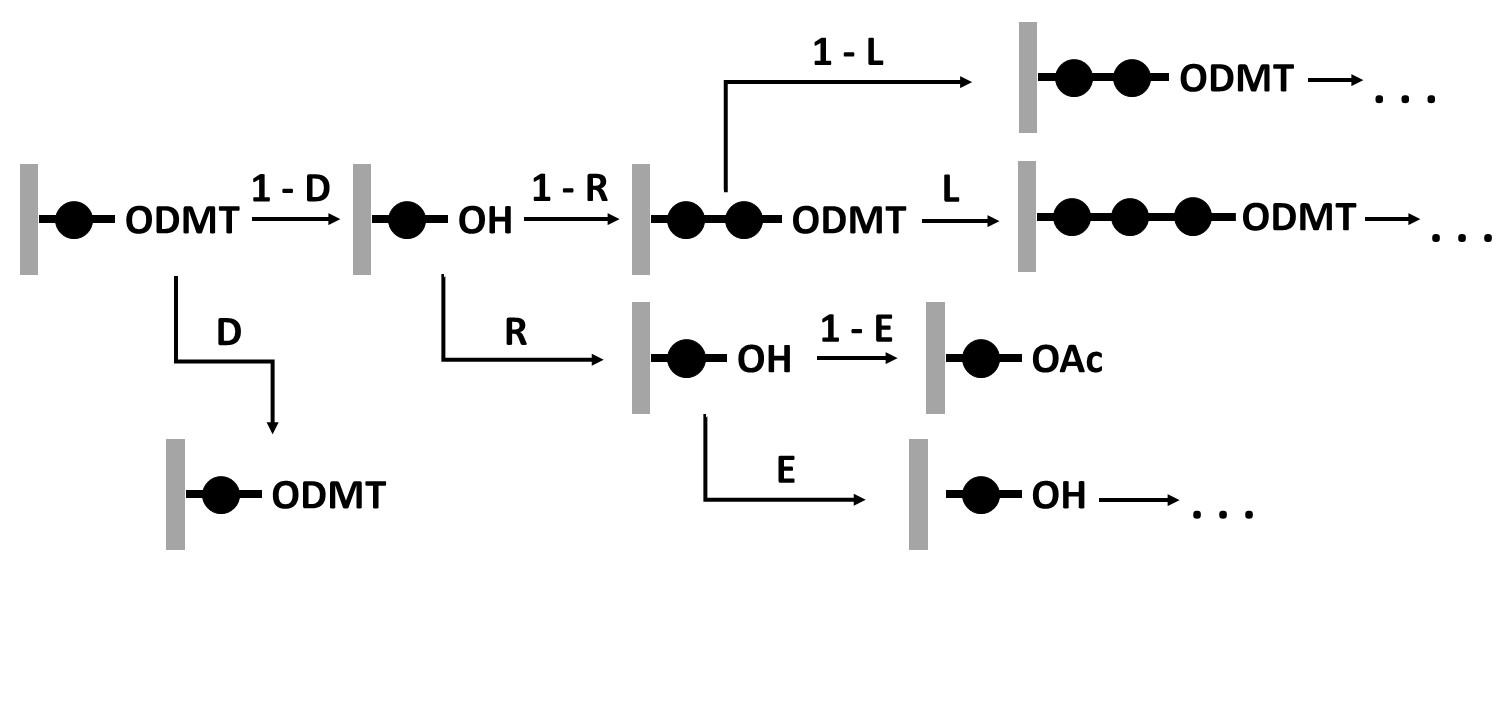

In [2]:
import numpy as np
import pandas as pd
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize': (20, 9)})

In [16]:
D = float(0.005) # вероятность ошибки на стадии снятия DMT защиты
R = float(0.01) # вероятность ошибки на стадии конденсации
E = float(0.005) # вероятность ошибки на стадии кэпирования
L = float(0.005) # вероятность дополниительной (повторной) конденсации
n = 40 # длинна олигонуклеотида
m = 2*n-1 # самый длинный возможный после окончания синтеза олигонуклеотид

permanent_list = [float(0)]*(2*n-1) # список с ацетилированными олигонуклеотидами

temp_list_1 = [[float(0), float(0)] for i in range(m)] # список с 3'-ODMT и 3'-OH олиго продуктами

temp_list_2 = [[float(0), float(0)] for i in range(m)] # список чтобы хранить продукты каждого нового цикла, 
# после завершения цикла информация из него переносится в temp_list_1 и он обнуляется, 
# т.е. освобождается для следующего цикла

temp_list_1[0][0] = float(1.0) # перед началом синтеза у нас имеется 100% защищенного моноамифофосфита на подложке

In [17]:
# Основная часть программы, проводится (n-1) цикл, считается распределение всех возможных продуктов.
for j in range(n-1):
    for i in range(2*j+1):
        FD = D * temp_list_1[i][0] #failed deprotection (i)
        SCNE = (1-D)*(1-R)*(1-L)*temp_list_1[i][0] # successful coupling no elongation (i+1)
        SCWE = (1-D)*(1-R)*L*temp_list_1[i][0] # successful coupling with elongation (i+2)
        FCSC = (1-D)*R*(1-E)*temp_list_1[i][0] # failed coupling successful capping
        FCFC = (1-D)*R*E*temp_list_1[i][0] # failed coupling failed capping (i)
        temp_list_2[i][0] += FD
        temp_list_2[i+1][0] += SCNE
        temp_list_2[i+2][0] += SCWE
        permanent_list[i] += FCSC
        temp_list_2[i][1] += FCFC
        SCNE2 = (1-R)*(1-L)*temp_list_1[i][1] # successful coupling no elongation (i+1)
        SCWE2 = (1-R)*L*temp_list_1[i][1] # successful coupling with elongation (i+2)
        FCSC2 = R*(1-E)*temp_list_1[i][1] # failed coupling successful capping
        FCFC2 = R*E*temp_list_1[i][1] # failed coupling failed capping
        temp_list_2[i+1][0] += SCNE2
        temp_list_2[i+2][0] += SCWE2
        permanent_list[i] += FCSC2
        temp_list_2[i][1] += FCFC2
    temp_list_1 = temp_list_2
    temp_list_2 = [[float(0), float(0)] for k in range(m)]


In [18]:
# Оформим результат в виде удобно читаемого датафрейма.
results_1 = np.array(temp_list_1)
results_2 = np.array(permanent_list).reshape(m,1)
results = np.append(results_1, results_2, axis=1)
results = pd.DataFrame(results)
results.columns = ["ODMT", "OH", "OAc"]
summ = results.sum(1)
results["probability"] = summ
results["length"] = [i for i in range(1, m+1)]
results

,ODMT,OH,OAc,probability,length
0,1.818989e-90,1.828176e-92,9.950498e-03,9.950498e-03,1
1,1.404295e-86,1.374823e-88,9.802228e-03,9.802228e-03,2
2,5.278995e-83,5.030758e-85,9.705425e-03,9.705425e-03,3
3,1.287498e-79,1.193436e-81,9.609330e-03,9.609330e-03,4
4,2.290234e-76,2.063297e-78,9.514188e-03,9.514188e-03,5
...,...,...,...,...,...
74,1.303948e-76,2.842692e-85,5.656998e-83,1.303948e-76,75
75,7.280524e-80,7.721548e-89,1.536588e-86,7.280526e-80,76
76,2.966387e-83,1.021099e-92,2.031986e-90,2.966388e-83,77
77,7.845499e-87,0.000000e+00,0.000000e+00,7.845499e-87,78


"from pylab import savefig\nimport matplotlib.pyplot as plt\nsb.barplot(x='length', y='probability', data=results)\nplt.savefig('DREL_error_distribution.png', dpi=300)"

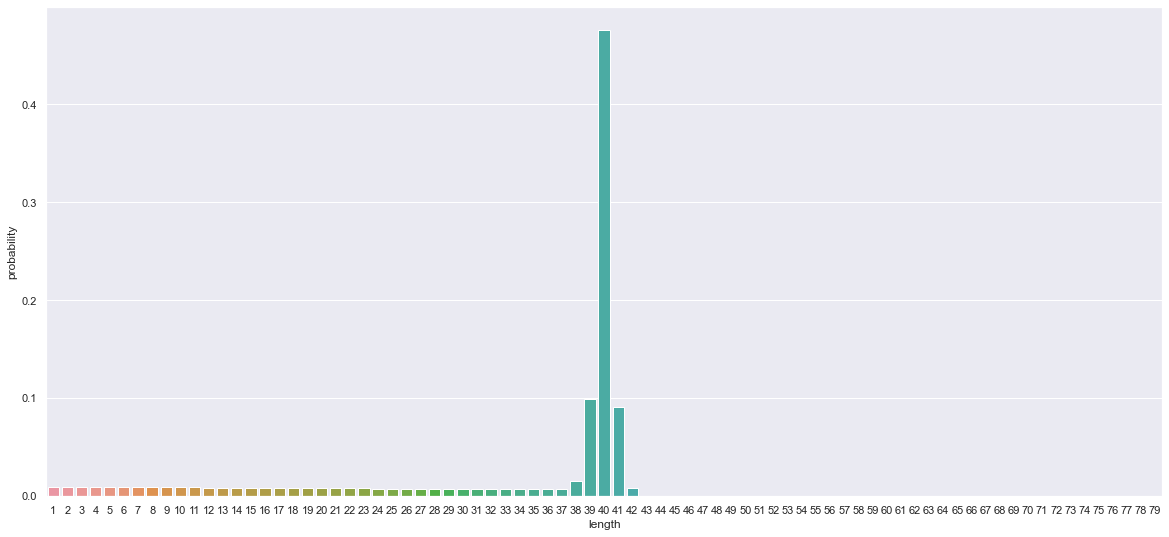

In [19]:
# Гистограмма распределения
sb.barplot(x="length", y='probability', data=results)
"""from pylab import savefig
import matplotlib.pyplot as plt
sb.barplot(x='length', y='probability', data=results)
plt.savefig('DREL_error_distribution.png', dpi=300)"""

In [20]:
# количество (n-1)-, n- и (n+1)-меров
after_purification = results.iloc[38:41,]
after_purification

,ODMT,OH,OAc,probability,length
38,0.093499,2.405128e-05,0.005758,0.099281,39
39,0.474745,4.506901e-06,0.000981,0.475731,40
40,0.091213,4.163399e-07,0.000088,0.091302,41


In [21]:
# считаем чистоту целевого олигонуклеотида после очистки, если (n-1)- и (n+1)-меры не отделились
yield_after_purification = after_purification.iloc[1,0]/(after_purification.iloc[0,0]+after_purification.iloc[1,0]+after_purification.iloc[2,0])

In [22]:
yield_after_purification

0.7199022398610544

Рассмотрим сборку гена А (777 п.о.) из 38 олигонуклеотидов длиной в 40 оснований с комплементарными мерекрывающимися учасками цепи в 20 оснований. Считаем, что олигонуклеотиды были очищены и после очиски в смеси находились только n-меры и (n-1)-меры. В данном случае считаем, что инсерции во время синтеза не происходили, т.е. L=0. Все остальные параметры такие же как и выше. Если предположить, что как правильный, так и неправильный (укороченный) ОН может включиться в собираемый ген с равной вероятностью, то для расчета вероятностей получения всех возможных вариаций гена (без делеций, с одной делецией, с двумя и т.д.) можно использовать биномиальное распределение. Для этого последовательно применим уравнение Бернулли чтобы найти вероятности всех возможных вариантов исхода событий.

In [23]:
import math

In [24]:
def gene_errors_prob(p,n,k):
    return math.factorial(n)/(math.factorial(k)*math.factorial(n-k))*(p**k)*((1-p)**(n-k))

In [25]:
probabilities = []
for i in range(0, 39):
    probabilities.append(gene_errors_prob(p=0.833,n=38,k = i))

In [26]:
probabilities = pd.DataFrame(probabilities)
probabilities.columns = ["Probability"]
probabilities["# of deletions in gene"] = [i for i in range(38,-1,-1)]
probabilities

,Probability,# of deletions in gene
0,2.905534e-30,38
1,5.507291e-28,37
2,5.082042e-26,36
3,3.041922e-24,35
4,1.327653e-22,34
5,4.503209e-21,33
6,1.235416e-19,32
7,2.817045e-18,31
8,5.444952e-17,30
9,9.053183e-16,29


In [27]:
sum(probabilities["# of deletions in gene"]*probabilities["Probability"])

6.346000000000002

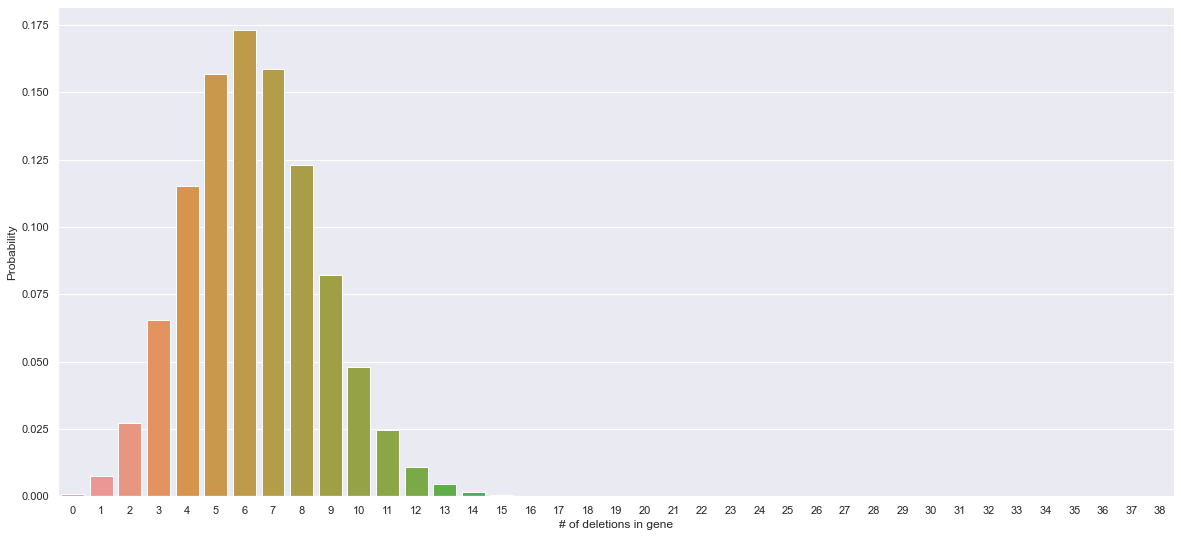

In [28]:
sb.barplot(x="# of deletions in gene", y="Probability", data=probabilities)
from pylab import savefig
import matplotlib.pyplot as plt
plt.savefig('DREL_error_distribution.png', dpi=300)